In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy

In [2]:
import matplotlib.pyplot as plt

In [3]:
def parse_chines(row):
    if row.chine[0] == '(':
        chine_list = row.chine[1:-1].split(',')
    else:
        chine_list = row.chine

    return chine_list


def r_to_l(val):
    def replace_l(s):
        return s[:-1] + 'l'
    if isinstance(val, str):
        if val[-1] == 'r':
            return replace_l(val)
    elif isinstance(val, list):
        vv = deepcopy(val)
        for i, v in enumerate(vv):
            if v[-1] == 'r':
                vv[i] = replace_l(v)
        return vv


def make_sym_offsets(df):

    ldf = df[df.y != 0]

    ldf.y *= -1
    ldf['pt'] = [r_to_l(p) for p in ldf.pt]
    ldf['chine'] = [r_to_l(chine) for chine in ldf.chine]
    return ldf

In [4]:
def make_sym_panel(pan):
    pan_c = deepcopy(pan)
    for station, ends in pan_c.items():
        for end, point in ends.items():
            if point[-1] == 'r':
                pan_c[station][end] = r_to_l(point)
    return pan_c

In [5]:
def make_sym_panels(panels):
    new_panels = {}
    for k, v in panels.items():
        if k[-1] == 'r':
            new_panels[r_to_l(k)] = make_sym_panel(v)
    return new_panels

In [6]:
def make_section_tris(pa, pb, point_df):
    point_list = list(pa.values()) + list(pb.values())

    coord_list = [point_df.loc[(point_df.pt == p), ['x', 'y', 'z']].values[0]
                  for p in point_list]

    coord_list = np.array(coord_list)

    if len(point_list) == 3:
        tri_list = [[0,1,2]]
    elif len(point_list) == 4:
        tri_list = [[0,2,1],
                    [1,3,2]]

    return coord_list, tri_list

In [7]:
def make_panel_tris(panel, point_df):
    ks = sorted(panel.keys())

    tri_tups = [make_section_tris(panel[k], panel[ks[i+1]], point_df)  
                for i, k in enumerate(ks[:-1])]
    
    tri_coords = np.vstack([t[0] for t in tri_tups])

    tri_list = []
    tri_line_counter = 0
    for t in tri_tups:
        tl = np.array(t[1])
        tl += tri_line_counter
        tri_list.append(tl)

        tri_line_counter += len(t[0])

    tri_list = np.vstack(tri_list)

    return tri_coords, tri_list

In [8]:
offsets = pd.read_excel('gc_draft_1_offsets.xlsx', sheet_name='points')

offsets['x'] = np.float_(offsets.x)
offsets['y'] = np.float_(offsets.y)
offsets['z'] = np.float_(offsets.z)

In [9]:
left_offsets = make_sym_offsets(offsets)

offsets = pd.concat((offsets, left_offsets), ignore_index=True)

for i, row in offsets.iterrows():
    if row.pt[-1] == 'c':
        if isinstance(row.chine, list):
            for c in row.chine:
                if c[-1] == 'r':
                    offsets.loc[i, 'chine'].append(r_to_l(c))


chine_list = []
for ch in offsets.chine:
    if isinstance(ch, str):
        if ch not in chine_list:
            chine_list.append(ch)
    elif isinstance(ch, list):
        for c in ch:
            if c not in chine_list:
                chine_list.append(c)

/Users/itchy/src/miniconda/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/itchy/src/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/itchy/src/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [10]:
def simplify_panel_tris(tri_coords, tri_list):
    new_tri_list = deepcopy(tri_list)
    unique_pts = []
    dup_d = {}

    for i, row in enumerate(tri_coords):
        dup_d[i] = []
        _row = tuple(row)
        if _row not in unique_pts:
            unique_pts.append(_row)
            new_tri_list[new_tri_list == i] = len(unique_pts) - 1
        else:
            prev_row = unique_pts.index(_row)
            new_tri_list[new_tri_list == i] = prev_row
            dup_d[i].append(prev_row)
            #n_adjust = len([new_tri_list.flatten() == prev_row])
            #new_tri_list[new_tri_list > i] -= n_adjust
    
    unique_inds = np.unique(new_tri_list)
    for i, ui in enumerate(unique_inds):
        new_tri_list[new_tri_list==ui] = i
            
    return np.array(unique_pts), new_tri_list, dup_d

In [11]:
panels = {
    'p0': {
        1: {'a': '1l',
            'b': '1r'},
        2: {'a': '6l',
            'b': '6r'},
        3: {'a': '11l',
            'b': '11r'},
        4: {'a': '16l',
            'b': '16r'},
        5: {'c': '20c'},
        0: {'a': '28l',
            'b': '28r'},
        -1:{'a': '32l',
            'b': '32r'},
        -2:{'a': '36l',
            'b': '36r'},
        -5:{'a': '40l',
            'b': '40r'},
        -6:{'a': '45l',
            'b': '45r'},
       -6.5:{'a': '48l',
             'b': '48r'},
    },
    'p1r': {
        1: {'a': '1r',
            'b': '2r'},
        2: {'a': '6r',
            'b': '7r'},
        3: {'a': '12r',
            'b': '13r'},
        4: {'a': '17r',
            'b': '18r'},
        5: {'a': '21r',
            'b': '22r'},
        6: {'a': '24c',
            'b': '25r'},
        7: {'p': '27c'},
        0: {'a': '28r',
            'b': '29r'},
        -1:{'a': '32r',
            'b': '33r'},
        -2:{'a': '36r',
            'b': '37r'},
        -5:{'a': '41r',
            'b': '42r'},
        -6:{'a': '45r',
            'b': '46r'},
       -6.5:{'c': '49r'}
    },
    'p2r': {
        1: {'a': '2r',
            'b': '3r'},
        2: {'a': '7r',
            'b': '8r'},
        3: {'a': '13r',
            'b': '14r'},
        4: {'c': '18r'},
        0: {'a': '29r',
            'b': '30r'},
        -1:{'a': '33r',
            'b': '34r'},
        -2:{'a': '37r',
            'b': '38r'},
        -5:{'a': '42r',
            'b': '43r'},
        -6:{'c': '46r'}
    },
    'p3r': {
        0: {'c': '30r'},
        1: {'a': '3r',
            'b': '4r'},
        2: {'a': '8r',
            'b': '9r'},
        3: {'c': '14r'}
    },
    'p4r': {
        0: {'c': '30r'},
        1: {'a': '4r',
            'b': '5c'},
        2: {'a': '9r',
            'b': '10c'},
        3: {'a': '14r',
            'b': '15c'},
        4: {'a': '18r',
            'b': '19c'},
        5: {'a': '22r',
            'b': '23c'},
        6: {'a': '25r',
            'b': '26c'},
        7: {'c': '27c'}
    },
    'p5r': {
        2: {'c': '6r'},
        3: {'a': '11r',
            'b': '12r'},
        4: {'a': '16r',
            'b': '17r'},
        5: {'a': '20c',
            'b': '21r'},
        6: {'c': '24c'}
    },
    'p6r': {
        0: {'c': '30r'},
        -1:{'a': '34r',
            'b': '35c'},
        -2:{'a': '38r',
            'b': '39c'},
        -5:{'a': '43r',
            'b': '44c'},
        -6:{'a': '46r',
            'b': '47c'},
      -6.5:{'a': '49r',
            'b': '50c'},
        -7:{'a': '51r',
            'b': '52c'}
    },
    'p7r': {
        -2:{'c': '36r'},
        -5:{'a': '40r',
            'b': '41r'},
        -6:{'c': '45r'}
    }
}

In [12]:
panels.update(make_sym_panels(panels))

In [13]:
ptc, ptl = make_panel_tris(panels['p0'], offsets)

In [14]:
stc, stl, dup_d = simplify_panel_tris(ptc, ptl)

In [15]:
stl

array([[ 0,  2,  1],
       [ 1,  3,  2],
       [ 2,  4,  3],
       [ 3,  5,  4],
       [ 4,  6,  5],
       [ 5,  7,  6],
       [ 6,  8,  7],
       [ 7,  9,  8],
       [ 8, 10,  9],
       [ 9, 11, 10],
       [10, 12, 11],
       [11, 13, 12],
       [12, 14, 13],
       [13, 15, 14],
       [14, 16, 15],
       [15, 17, 16],
       [16, 18, 17],
       [17, 19, 18],
       [18, 19, 20]])

In [16]:
ptl.shape, stl.shape

((19, 3), (19, 3))

In [17]:
def v_norm(v):
    va = np.array(v)
    if va[-1] < 0:
        va *= -1
    return va.T / np.sqrt(np.sum(va**2))

def get_normal(tri_coords):
    return v_norm(np.cross(tri_coords[0] - tri_coords[-1], 
                           tri_coords[1] - tri_coords[-1]))


def make_rot_matrix_from_normal(norm_vec):
    """ from https://math.stackexchange.com/questions/1956699/
        getting-a-transformation-matrix-from-a-normal-vector"""
    
    if np.all(np.abs(norm_vec) == np.array([0,0,1])):
        return np.eye(3)
    
    else:
        nx, ny, nz = norm_vec
        
        denom = np.sqrt(nx**2 + ny**2)
        
        l1 = [ny / denom, 
              -nx / denom, 
              0.]
        
        l2 = [nx*nz / denom, 
              ny*nz / denom,
              -denom]
        
        l3 = [nx, ny, nz]
        
        return np.array([l1, l2, l3])

In [18]:
def rotate_points(points, hinge_pt=np.array([0,0,0]), 
                  add_hinge_back=True):
    
    #points = points - hinge_pt
    hinge_pt = np.mean(points, axis=0)
    trans_points = points - hinge_pt
    #print(trans_points)
    
    norm_vec = get_normal(trans_points)
    
    R = make_rot_matrix_from_normal(norm_vec)
    
    rot_points = trans_points @ R.T
    
    if add_hinge_back:
        rot_points += hinge_pt
        
    return rot_points

In [19]:
rotated_tris = {}

for i, tri in enumerate(stl):
    tri_coords = stc[tri]
    try:
        rotated_tris[i] = rotate_points(tri_coords,
                                    #hinge_pt=tri_coords[1],
                                    add_hinge_back=False)
    except Exception as e:
        print(i, e)
    
    

In [20]:
def get_forward_point(tri):
    fp_x = tri[:,2].max()
    
    for t in tri:
        if t[2] == fp_x:
            return t
        
def get_backward_point(tri):
    bp_x = tri[:,0].min()
    
    for t in tri:
        if t[0] == bp_x:
            return t

In [21]:
def detect_shared_edges(t0, t1):
    shared_pts = [p for p in t0
                  if p in t1]
    if len(shared_pts) == 2:
        return {'edge_pts': shared_pts}
    else:
        return None

In [22]:
detect_shared_edges(stl[0], stl[1])

{'edge_pts': [2, 1]}

In [23]:
def make_adj_dict(tris, pts):
    adj_dict = {(i, j+i): detect_shared_edges(t0, t1)
                for i, t0 in enumerate(tris)
                for j, t1 in enumerate(tris[i:])}
    
    adj_dict = {k: v for k, v in adj_dict.items()
                if v is not None}
    
    for k, v in adj_dict.items():
        v['coords'] = pts[v['edge_pts']]
        
        first = k[0]
        tf = tris[first].tolist()
        v['first_tri_vertex_inds'] = [tf.index(p)
                                    for p in v['edge_pts']]
        second = k[1]
        ts = tris[second].tolist()
        v['second_tri_vertex_inds'] = [ts.index(p)
                                     for p in v['edge_pts']]
    
    return adj_dict

In [26]:
p0_adj = make_adj_dict(stl, stc)

In [27]:
get_forward_point(p0_adj[(0,1)]['coords'])

array([-197.,    7.,   22.])

In [28]:
p0_adj[(2,3)]

{'coords': array([[-130. ,  -15. ,    9.5],
        [-193. ,    8. ,   18. ]]),
 'edge_pts': [4, 3],
 'first_tri_vertex_inds': [1, 2],
 'second_tri_vertex_inds': [2, 0]}

next steps:
 1. [x] rotate each tri to flat (z=0), arbitrary coords
 2. [ ] connect tris along shared edges
     a. [x] translate each tri to one matching coord from previous tri
     b. [x] rotate second tri to share boundary with first
     c. [ ] reflect second tri if necessary
 3. [ ] profit

In [30]:
rotated_tris = {k:v[:,0:2] for k,v in rotated_tris.items()}

In [31]:
def translate_tri_coords(tri_coords, trans_vec):
    return tri_coords - trans_vec

In [32]:
p0_adj[(0,1)]

{'coords': array([[-193.,   -8.,   18.],
        [-197.,    7.,   22.]]),
 'edge_pts': [2, 1],
 'first_tri_vertex_inds': [1, 2],
 'second_tri_vertex_inds': [2, 0]}

In [215]:
def rotate_tri_to_match(tri_1, tri_2, first_vertex_inds, 
                        second_vertex_inds, cr=False):
    
    hinge = tri_1[first_vertex_inds[0]]
    
    #print('hinge', hinge)
    
    vector_1 = tri_1[first_vertex_inds[1]] - hinge
    vector_2 = tri_2[second_vertex_inds[1]] - hinge
    
    vector_1 /= np.sqrt(np.sum(vector_1**2))
    vector_2 /= np.sqrt(np.sum(vector_2**2))
    
    #print(vector_1, vector_2)
    
    #rot_angle = -np.arccos(np.clip(vector_1.dot(vector_2), -1.0, 1.0))
    rot_angle = -np.arctan2(np.linalg.det([vector_1, vector_2]),
                            np.dot(vector_1, vector_2))
    
    #print(vector_1.dot(vector_2))
    
    rot_mat = np.array([[np.cos(rot_angle), -np.sin(rot_angle)],
                        [np.sin(rot_angle), np.cos(rot_angle)]])
    
    tri_2_rot = ((tri_2 - hinge) @ rot_mat.T) + hinge
    
    #plt.plot(*get_tri_xys(tri_1))
    #plt.plot(*get_tri_xys(tri_2))
    #plt.plot(*get_tri_xys(tri_2_rot))

    if cr is True:
        tri_2_rot = check_and_reflect(tri_1, tri_2_rot, first_vertex_inds,
                                      second_vertex_inds)
        
    
    return tri_2_rot    

In [216]:
rotate_tri_to_match(p1_unfold[0],
                  p1_unfold[1],
                  p1_adj[(0,1)]['first_tri_vertex_inds'],
                  p1_adj[(0,1)]['second_tri_vertex_inds'])

array([[ 4.58946719e+00,  8.88463792e+00],
       [-5.35503729e+01,  3.59910761e+01],
       [-8.88178420e-16, -1.77635684e-15]])

In [217]:
p1_unfold[0]

array([[ 5.63618778, -1.11057974],
       [ 4.58946719,  8.88463792],
       [ 0.        ,  0.        ]])

In [176]:
p1_unfold[1]

array([[  4.58946719,   8.88463792],
       [-57.67513533,  -6.5464759 ],
       [  6.59961984,  -0.91124317]])

In [177]:
p1_adj[(0,1)]

{'coords': array([[-193.,    8.,   18.],
        [-193.,   14.,   26.]]),
 'edge_pts': [1, 2],
 'first_tri_vertex_inds': [1, 2],
 'second_tri_vertex_inds': [0, 2]}

In [35]:
def get_tri_xys(tri_pts):
    return (np.append(tri_pts[:,0], tri_pts[0,0]),
            np.append(tri_pts[:,1], tri_pts[0,1]))

In [36]:
rotate_tri_to_match(trans_tris[0], trans_tris[1],
                    p0_adj[(0,1)]['first_tri_vertex_inds'],
                    p0_adj[(0,1)]['second_tri_vertex_inds'])

array([[-2.03502976e-07,  5.39618787e-07],
       [-1.00000000e+00,  5.65685483e+00],
       [ 1.50000000e+01,  5.65685425e+00]])

In [38]:
def rotate_tri_num(tri_num, cr=False):
    tri_rot = rotate_tri_to_match(trans_tris[tri_num-1],
                                  trans_tris[tri_num],
                                  p0_adj[(tri_num-1,tri_num)]['first_tri_vertex_inds'],
                                  p0_adj[(tri_num-1,tri_num)]['second_tri_vertex_inds'])
    
    if cr is True:
        tri_rot = check_and_reflect(trans_tris[tri_num-1],
                                    tri_rot,
                                   p0_adj[(tri_num-1,tri_num)]['first_tri_vertex_inds'],
                                  p0_adj[(tri_num-1,tri_num)]['second_tri_vertex_inds'])
        
    return tri_rot

In [37]:
#trans_tris[6] = check_and_reflect(trans_tris[5],
#                  trans_tris[6],
#                 p0_adj[(5,6)]['first_tri_vertex_inds'],
#                 p0_adj[(5,6)]['second_tri_vertex_inds'])

In [137]:
trans_tris = {}
for i, tri_pts in rotated_tris.items():
#for i in range(6):
#for i in [6]:
    #print(i)
    tri_pts = rotated_tris[i]
    if i == 0:
        trans_tris[i] = translate_tri_coords(tri_pts,
                                             get_backward_point(tri_pts))
        #trans_tris[i] = trans_tris[i] @ np.array([[np.cos(np.pi/4), np.sin(np.pi/2)],
        #                                          [-np.sin(np.pi/2), np.cos(np.pi/2)]])
        
    else:
        first_tri_match_ind = p0_adj[(i-1,i)]['first_tri_vertex_inds'][0]
        first_tri_match_pt = trans_tris[i-1][first_tri_match_ind]
        second_tri_match_pt = tri_pts[p0_adj[(i-1,i)]['second_tri_vertex_inds'][0]]
        trans_tris[i] = translate_tri_coords(tri_pts, second_tri_match_pt-first_tri_match_pt)
        
        trans_tris[i] = rotate_tri_to_match(trans_tris[i-1], trans_tris[i],
                                            p0_adj[(i-1,i)]['first_tri_vertex_inds'],
                                            p0_adj[(i-1,i)]['second_tri_vertex_inds'])
        
        if np.all(trans_tris[i][p0_adj[(i-1,i)]['second_tri_vertex_inds']] != 
                 trans_tris[i-1][p0_adj[(i-1,i)]['first_tri_vertex_inds']]):
            #print(i, 'not match')
    
        
    

SyntaxError: unexpected EOF while parsing (<ipython-input-137-61f987d121d6>, line 28)

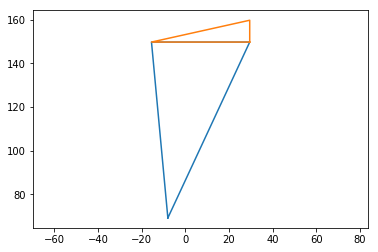

In [96]:
plt.plot(*get_tri_xys(trans_tris[5]))
plt.plot(*get_tri_xys(trans_tris[6]))
#plt.plot(*get_tri_xys(rotate_tri_num(6, cr=False)))

plt.axis('equal')

plt.show()

In [39]:
#trans_tris[8] = rotate_tri_num(8, cr=False)

/Users/itchy/src/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arccos
  if sys.path[0] == '':


(-17.750002717446762,
 31.749999137014562,
 -19.531529506331285,
 410.16211471557386)

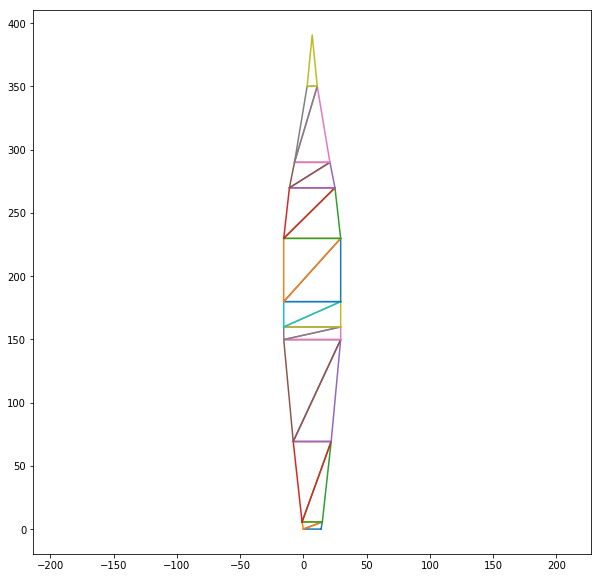

In [99]:
plt.figure(figsize=(10,10))

#for i, tri_pts in trans_tris.items():
plt.plot(*get_tri_xys(trans_tris[0]))
for i in range(1,19):
    tri_pts = trans_tris[i]
    plt.plot(*get_tri_xys(tri_pts))
    #plt.plot(*get_tri_xys(rotate_tri_num(i)))
    
    
    

    
    
#plt.plot(*get_tri_xys(rotate_tri_num(9, cr=True)))    
    
#plt.plot(*get_tri_xys(rotate_tri_to_match(trans_tris[6], trans_tris[7],
#                    p0_adj[(6,7)]['first_tri_vertex_inds'],
#                    p0_adj[(6,7)]['second_tri_vertex_inds'])))

#plt.plot(*get_tri_xys(check_and_reflect(trans_tris[5],
#                  trans_tris[6],
#                 p0_adj[(5,6)]['first_tri_vertex_inds'],
#                 p0_adj[(5,6)]['second_tri_vertex_inds'])))

plt.axis('equal')

In [412]:
rotated_tris.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [123]:
p1tc, p1tl = make_panel_tris(panels['p1r'], offsets)
s1tc, s1tl, dup_d_1 = simplify_panel_tris(p1tc, p1tl)
p1_adj = make_adj_dict(s1tl, s1tc)


In [ ]:
rotated_tris = {}

for i, tri in enumerate(stl):
    tri_coords = stc[tri]
    try:
        rotated_tris[i] = rotate_points(tri_coords,
                                    #hinge_pt=tri_coords[1],
                                    add_hinge_back=False)
    except Exception as e:
        print(i, e)

In [113]:
def rotate_panel_tris(tri_list, tri_coords):
    #rtps = {rotate_points(tcs, add_hinge_back=False)}
    rtps = {}
    for i, tri in enumerate(tri_list):
        tcs = tri_coords[tri]
        try:
            rtps[i] = rotate_points(tcs, add_hinge_back=False)[:,0:2]
        except Exception as e:
            print(i, e)
    
    return rtps
    
    

In [114]:
p1_rs = rotate_panel_tris(s1tl, s1tc)

In [ ]:
trans_tris = {}
for i, tri_pts in rotated_tris.items():
#for i in range(8,19):
#for i in [7]:
    tri_pts = rotated_tris[i]
    if i == 0:
        trans_tris[i] = translate_tri_coords(tri_pts,
                                             get_backward_point(tri_pts))
        #trans_tris[i] = trans_tris[i] @ np.array([[np.cos(np.pi/4), np.sin(np.pi/2)],
        #                                          [-np.sin(np.pi/2), np.cos(np.pi/2)]])
        
    else:
        first_tri_match_ind = p0_adj[(i-1,i)]['first_tri_vertex_inds'][0]
        first_tri_match_pt = trans_tris[i-1][first_tri_match_ind]
        second_tri_match_pt = tri_pts[p0_adj[(i-1,i)]['second_tri_vertex_inds'][0]]
        trans_tris[i] = translate_tri_coords(tri_pts, second_tri_match_pt-first_tri_match_pt)
        
        trans_tris[i] = rotate_tri_to_match(trans_tris[i-1], trans_tris[i],
                                            p0_adj[(i-1,i)]['first_tri_vertex_inds'],
                                            p0_adj[(i-1,i)]['second_tri_vertex_inds'])

In [219]:
def unfold_panels(rot_panel, adj_dict, cr=True):
    unfolded_tris = {}
    
    for i, tri_pts in rot_panel.items():
        if i == 0:
            unfolded_tris[i] = translate_tri_coords(tri_pts,
                                                    get_backward_point(tri_pts))
        else:
            first_tri_vertexes = adj_dict[(i-1,i)]['first_tri_vertex_inds']
            second_tri_vertexes = adj_dict[(i-1,i)]['second_tri_vertex_inds']
            
            first_tri_match_pt = unfolded_tris[i-1][first_tri_vertexes[0]]
            second_tri_match_pt = tri_pts[second_tri_vertexes[0]]
            
            translated_tri = translate_tri_coords(tri_pts, second_tri_match_pt-first_tri_match_pt)
            
            unfolded_tris[i] = rotate_tri_to_match(unfolded_tris[i-1], translated_tri,
                                                   first_tri_vertexes,
                                                   second_tri_vertexes, cr=cr)
            
    return unfolded_tris
            

In [220]:
p1_unfold = unfold_panels(p1_rs, p1_adj, cr=False)

(-388.99180301380795,
 24.427996860809195,
 -10.111115799650968,
 187.9006775197394)

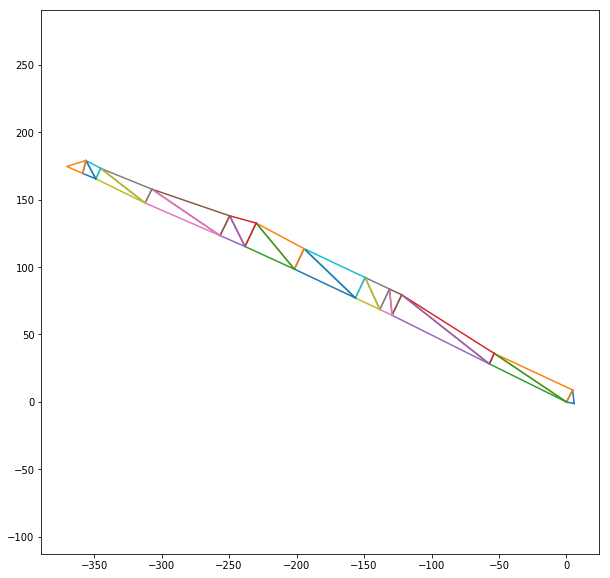

In [221]:
plt.figure(figsize=(10,10))


    
for i, tri_pts in p1_unfold.items():
    plt.plot(*get_tri_xys(tri_pts))
    
plt.axis('equal')

In [222]:
p1tc, p1tl = make_panel_tris(panels['p1r'], offsets)
s1tc, s1tl, dup_d_1 = simplify_panel_tris(p1tc, p1tl)
p1_adj = make_adj_dict(s1tl, s1tc)

In [223]:
def panel_unfold_all(panel, station_offsets, cr=False):
    
    panel_coords, panel_tris = make_panel_tris(panel, station_offsets)
    
    simp_panel_coords, simp_panel_tris, dup_dict = simplify_panel_tris(panel_coords,
                                                                       panel_tris)
    
    adj_d = make_adj_dict(simp_panel_tris, simp_panel_coords)
    
    rotated_tris = rotate_panel_tris(simp_panel_tris, simp_panel_coords)
    
    unfolded_tris = unfold_panels(rotated_tris, adj_d, cr=cr)
    
    return unfolded_tris
    

In [224]:
%%timeit

panel_unfold_all(panels['p2r'], offsets)

49 ms ± 7.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [230]:
p2u = panel_unfold_all(panels['p2r'], offsets)

(-10.879628346962749,
 228.47219528621773,
 -57.556574906189155,
 30.256996196899024)

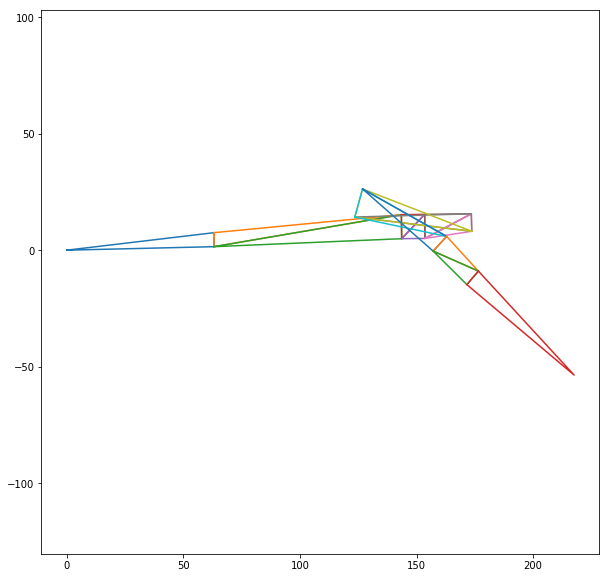

In [238]:
plt.figure(figsize=(10,10))
  
for i, tri_pts in panel_unfold_all(panels['p2r'], offsets, cr=False).items():
    plt.plot(*get_tri_xys(tri_pts))
    
plt.axis('equal')


In [163]:
def check_and_reflect(tri_1, tri_2, first_vertex_inds, second_vertex_inds):
    
    plt.figure()
    
    plt.plot(*get_tri_xys(tri_1))
    plt.plot(*get_tri_xys(tri_2))
    
    
    hinge = tri_1[first_vertex_inds[0]]
    
    vector_1 = tri_1[first_vertex_inds[1]] - hinge
    vector_1 /= np.sqrt(np.sum(vector_1**2))
    
    rot_angle = -np.arccos(vector_1.dot(np.array([0,1])))
    
    rot_mat = np.array([[np.cos(rot_angle), np.sin(rot_angle)],
                        [-np.sin(rot_angle), np.cos(rot_angle)]])
    
    t1r = (tri_1-hinge) @ rot_mat.T
    t2r = (tri_2-hinge) @ rot_mat.T
    
    t1_other_ind = list(set([0,1,2])-set(first_vertex_inds))[0]
    t2_other_ind = list(set([0,1,2])-set(second_vertex_inds))[0]
    
    t1r_other_pt = t1r[t1_other_ind]
    t2r_other_pt = t2r[t2_other_ind]
    
    if np.sign(t1r_other_pt[1]) != np.sign(t2r_other_pt[1]):
        
        return tri_2
    
    else:
        t2r[t2_other_ind][0] *= -1
        
        back_rot_mat = np.array([[np.cos(-rot_angle), np.sin(-rot_angle)],
                                 [-np.sin(-rot_angle), np.cos(-rot_angle)]])
        
        return (t2r @ back_rot_mat.T) + hinge

array([[ 4.58946719e+00,  8.88463792e+00],
       [-5.35503729e+01,  3.59910761e+01],
       [-8.88178420e-16, -1.77635684e-15]])

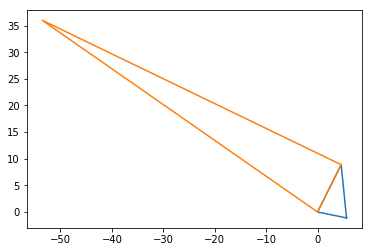

In [237]:
check_and_reflect(p1_unfold[0],
                  p1_unfold[1],
                  p1_adj[(0,1)]['first_tri_vertex_inds'],
                  p1_adj[(0,1)]['second_tri_vertex_inds'])

In [165]:
p1_unfold[0]

array([[ 5.63618778, -1.11057974],
       [ 4.58946719,  8.88463792],
       [ 0.        ,  0.        ]])

In [166]:
p1_unfold[1]

array([[  4.58946719,   8.88463792],
       [-57.67513533,  -6.5464759 ],
       [  6.59961984,  -0.91124317]])